In [539]:
import numpy as np
from numpy import newaxis as NA
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
sigma, epsilon = 3.401, 0.997

# Solving nonlinear eq. in 1D

# a. Lennard Jones Energy 

In [540]:
def distance(points):
    """Calculates Euclidean distance between N points. points is an Nx3 array."""
    displacement = points[:,NA]-points[NA,:] #(N,N,3) displacement vector
    return np.sqrt(np.sum(displacement*displacement , axis=-1))

In [541]:
def div_0(a,b): 
    """Divides a by b. If b==0 returns 0."""
    return np.divide(a, b, out=np.zeros_like(b), where=b!=0)

In [542]:
def LJ(sigma, epsilon):
    """Creates the function V which computes the LJ potential with specified\
    sigma and epsilon."""
    def V(points):
        """Returns the Energy of N particle system given coordinates (Nx3) in the\
        Lennard Jones potential."""
        r = distance(points)
        N = len(r)
        #take only upper triangular part of the matrix since dist(ij)=dist(ji)
        r = np.triu(r)
        return np.sum(4*epsilon*((div_0(sigma,r))**12-(div_0(sigma,r))**6))
    return V

In [543]:
N = 200
range0 = np.linspace(3,11,N)
Points = np.zeros((N,4,3))
Points[:,0,0] = range0
Points[:,2,0] = 14
Points[:,3,[0,1]] = [7,3.2]
E2, E4 = np.empty(shape = N), np.empty(shape = N)
V = LJ(sigma, epsilon)
for i in range(N): #Computing LJ energy for N coordinates
    E2[i] = V(Points[i,:2,:])
    E4[i] = V(Points[i,:,:])

In [544]:
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(range0, E2, label = '2 atoms'), ax.plot(range0, E4, label = '4 atoms')
ax.set_ylabel('E [kJ/mol]', fontsize = 15), ax.legend(fontsize = 15)
ax.set_xlabel(r'distance [Angstrom]', fontsize = 15)
ax.set_title(r'Lennard Jones Potential', fontsize = 15)
plt.show()

<IPython.core.display.Javascript object>

# b. Bisection Method

In [545]:
def bis(f,a,b,tol, max_iter = 1000):
    """Bisection method for finding roots of a funciton f given an interval [a,b]
    where sign(f(a))!=sign(f(b)).\nReturns: Root x within the given tolerance 
    number of function calls n_calls."""
    fa, fb = f(a), f(b)
    assert(np.sign(fa)!=np.sign(fb))
    n_calls = int(np.ceil(np.log2((b-a)/tol)))
    if max_iter < n_calls: 
        n_calls = max_iter
    x = (a+b)/2
    for i in range(n_calls):
        fx = f(x)
        if np.sign(fx)==np.sign(fa):
            a = x
        else:
            b = x
        x = (a+b)/2
    return x, n_calls+2

In [546]:
def Vx(x):
    """Helper function to call V with a range of different x in the 1d case."""
    return V(np.array([np.zeros(3), np.array([0,0,x])]))

x_root,n = bis(Vx,2,6,1e-13)
x_root, n, Vx(x_root)

(3.400999999999982, 48, 1.275139993595076e-13)

48 function calls are necessary 

# c. Newton Raphson method

In [547]:
def DV(r,sigma = sigma, epsilon = epsilon):
    """Derivative of the Lennard-Jones potential."""
    return 4*epsilon*(6*sigma**6/r**7 - 12*sigma**12/r**13)

In [548]:
def newton_root(f, df, x0, tol, max_iter):
    """Newton-Rhapson method to find root of a function f.\nReturns:
    root of f x0 within tolerance or last computed x0 if n_calls reaches max_iterations
    number of function calls n_calls."""
    f0 = f(x0)
    n_calls = 1
    while (abs(f0)>tol) and (n_calls<max_iter):
        n_calls+=2
        x0 = x0-f0/df(x0)
        f0 = f(x0)
    return x0, n_calls
x_newton, n_calls = newton_root(Vx, DV, 2, 1e-12,100)
x_newton, n_calls, Vx(x_newton)

(3.400999999999998, 25, 1.0626166613292299e-14)

25 function calls are needed 

# d. Combination of NR and bisection method 

In [549]:
def NR_bis(f, df, a, b, x0, tolerance):
    """Root finding using a combination of Newton Rhapson and bisection
    which guarantees convergence.\n Returns:\n root x0\n number of function calls n_calls"""
    f0 = f(x0)
    n_calls = 1
    while abs(f0)>tolerance:
        n_calls += 1
        xn = x0-f0/df(x0) #if new point is outside of [a,b] execute bisection
        if ((xn<a) or (xn>b)):
            n_calls+=2
            fa = f(a)
            x0 = (a+b)/2
            f0 = f(x0)
            if np.sign(f0)==np.sign(fa):
                a = x0
            else:
                b = x0
        else:
            x0 = xn
            n_calls += 1
            f0 = f(x0)
    return x0, n_calls

NR_bis(Vx, DV, 2, 4, 2, 1e-13)

(3.400999999999998, 25)

25 function calls were needed 

# Solving Nonlinear equations in N dimensions

# e. 

In [550]:
def LJgradient(sigma, epsilon):
        """Returns: derivative of LJ potential gradV(X) with given sigma and epsilon."""
        def gradV(X):
            """Given an the coordinates of N points in an (N,3) array \nreturns:
            gradient in the 3N dimensional space."""
            d = X[:,NA]-X[NA,:] #(N,N,3) displacement vector
            r = np.sqrt(np.sum(d**2, axis=-1)) #(N,N) distances
            np.fill_diagonal(r,1)
            T = 6*sigma**6/(r**7) - 12*sigma**12/(r**13) # (N,N) derivatives matrix
            u = d/r[:,:,NA] #u is (N,N,3) array of unit vectors in dir Xi-Xj
            return 4*epsilon*np.sum(T[:,:,NA]*u, axis = 1)
        return gradV
gradV = LJgradient(sigma,epsilon)

In [551]:
def Fx(x,f):
    """Helper function, compute function F: R^3->R on a 1d subspace."""
    return f(np.array([np.zeros(3), np.array([0,0,x])]))

In [552]:
range1 = np.linspace(3,10,N)
gradient = np.empty(shape = (N,2,3))
for i in range(N):
    gradient[i] = Fx(range1[i],gradV)

In [553]:
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(range0, E2, label = 'LJ')
ax.plot(range1, gradient[:,1,2], label = 'gradLJ')
ax.set_ylabel('E [kJ/mol]', fontsize = 15), ax.legend(fontsize = 15)
ax.set_xlabel(r'distance [Angstrom]', fontsize = 15)
ax.set_title(r'Lennard Jones Potential 2 particles', fontsize = 15)
ax.set_xlim(3,10)
plt.show()

<IPython.core.display.Javascript object>

# f. Line search 

In [554]:
def linesearch(F, X0, d, alpha_max, tol, max_iter):
    """Returns: X = X0+alpha*d such that d@F(X)=0 within tolerance tol or X that
    was computed in the last step once max_iter is reached.\n number of
    function calls."""
    F_restricted = lambda alpha: F(X0 + alpha*d).flatten()
    gradF_restricted = lambda s: d.flatten()@F_restricted(s)
    alpha, n_calls = bis(gradF_restricted, 0, alpha_max, tol, max_iter)
    return X0+alpha*d, n_calls, alpha

## Test 

In [555]:
X0 = np.zeros((4,3))
X0[:,0], X0[-1,1] = [4,0,14,7], 3.2
d = -gradV(X0)
X_min, n_calls, _ = linesearch(gradV, X0, d, 1, 1e-12, 400)
d.flatten()@gradV(X_min).flatten(), n_calls

(-1.902866753056287e-12, 42)

# Nonlinear Optimization (Week 5) 

In [556]:
ArStart = np.load('ArStart.npz')
Xstart2 = ArStart['Xstart2']

In [557]:
def flatten_func(f): return lambda X: f(X.reshape(-1,3))
def flatten_grad(f): return lambda X: f(X.reshape(-1,3)).reshape(-1)

# g. Golden section search

In [558]:
phi = (1 + 5**0.5) / 2
def golden_section_min(f, a, b, tol = 1e-3):
    """For a strictly unimodal function on the interval [a,b], using golden section search
    Returns: \nminimum x_opt\nnumber of function calls .
    """
    n_calls = 0
    c = b - (b-a)/phi
    d = a + (b-a)/phi
    while abs(c-d)>tol:
        n_calls +=2
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b - a) / phi
        d = a + (b - a) / phi
    return (b+a)/2, n_calls 

## Obtain $\alpha$ 

In [559]:
X_test = np.copy(X0)
alpha_gs, n_calls_gs = golden_section_min(lambda s: V(X_test+s*d), 0,1)
X_min_gs = X_test+alpha_gs*d
d.flatten()@gradV(X_min_gs).flatten(), n_calls

(0.0038784597995839554, 42)

## Find optimal distance between 2 Ar atoms 

In [560]:
X_min_2gs, n_calls_2gs = golden_section_min(Vx, 0,10)
print("r0 = {:3.3}".format(X_min_2gs))

r0 = 3.82


# h. Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm 

In [583]:
def BFGS(f, gradf, X, tol = 1e-6, max_iter = 10000):
    N_calls, converged = 0, True
    X = np.copy(X)
    dfX0 = gradf(X)
    B = np.eye(len(X))#*la.norm(dfX0)/0.01
    while(abs(la.norm(dfX0))>tol and N_calls<=max_iter):
        N_calls+=2
        dx = la.solve(B,-dfX0)
        X = X + dx
        dfX = gradf(X)
        dy = dfX-dfX0
        dfX0 = dfX
        #print(np.outer(dy,dy))
        B += np.outer(dy,dy)/(dy@dx) - np.outer(B@dx, B@dx)/(dx@(B@dx))
    if N_calls>=max_iter:
        converged = False
    return X, N_calls, converged

In [584]:
V_flat = flatten_func(V)
dV_flat = flatten_grad(gradV)
X_min2, calls2, conv2 = BFGS(V_flat, dV_flat, Xstart2, tol = 1e-4, max_iter = 100)
r0_BFGS =la.norm(X_min2[:3]-X_min2[3:])
print("r0 = {:3.3}".format(r0_BFGS))

r0 = 3.82


##  Book example

In [563]:
def ftest(x): return .5*x[0]**2+2.5*x[1]**2
def dftest(x): return np.array([x[0],5*x[1]])
x0 = np.array([5,1])
x,_,_ = BFGS(ftest,dftest, x0,1e-5,1)

# i. N-particle system 

In [564]:
ArStarts = []
for key, value in ArStart.items():
    temp = [key,value]
    ArStarts.append(temp)

In [634]:
def BFGS(f, gradf, X, tol = 1e-6, max_iter = 10000):
    N_calls, converged = 0, True
    X = np.copy(X)
    dfX0 = gradf(X)
    B = np.eye(len(X))*la.norm(dfX0)/0.01
    while(abs(la.norm(dfX0))>tol and N_calls<=max_iter):
        N_calls+=2
        dx = la.solve(B,-dfX0)
        X = X + dx
        dfX = gradf(X)
        dy = dfX-dfX0
        dfX0 = dfX
        B += (np.outer(dy,dy)/(dy@dx) - np.outer(B@dx, B@dx)/(dx@(B@dx)))*1e-3
    if N_calls>=max_iter:
        converged = False
    return X, N_calls, converged

In [635]:
X_min_N, calls_N, conv_N, Distance_N, num_within = [],[],[],[],[]
for i in range(len(ArStarts)):
    X_min, calls, conv = BFGS(V_flat, dV_flat, ArStarts[i][1], tol = 1e-6, max_iter = 30000)
    d = distance(X_min.reshape(-1,3))
    X_min_N.append(X_min), calls_N.append(calls)
    conv_N.append(conv), Distance_N.append(d)
    num_within.append(np.sum(abs(Distance_N[i]-r0_BFGS)/r0_BFGS <= .01))

In [638]:
num_within, calls_N

([2, 6, 12, 18, 24, 30, 36, 38],
 [16, 688, 1010, 4856, 7468, 7530, 5372, 13672])

### Num of particels within 1% of r0 

<IPython.core.display.Javascript object>


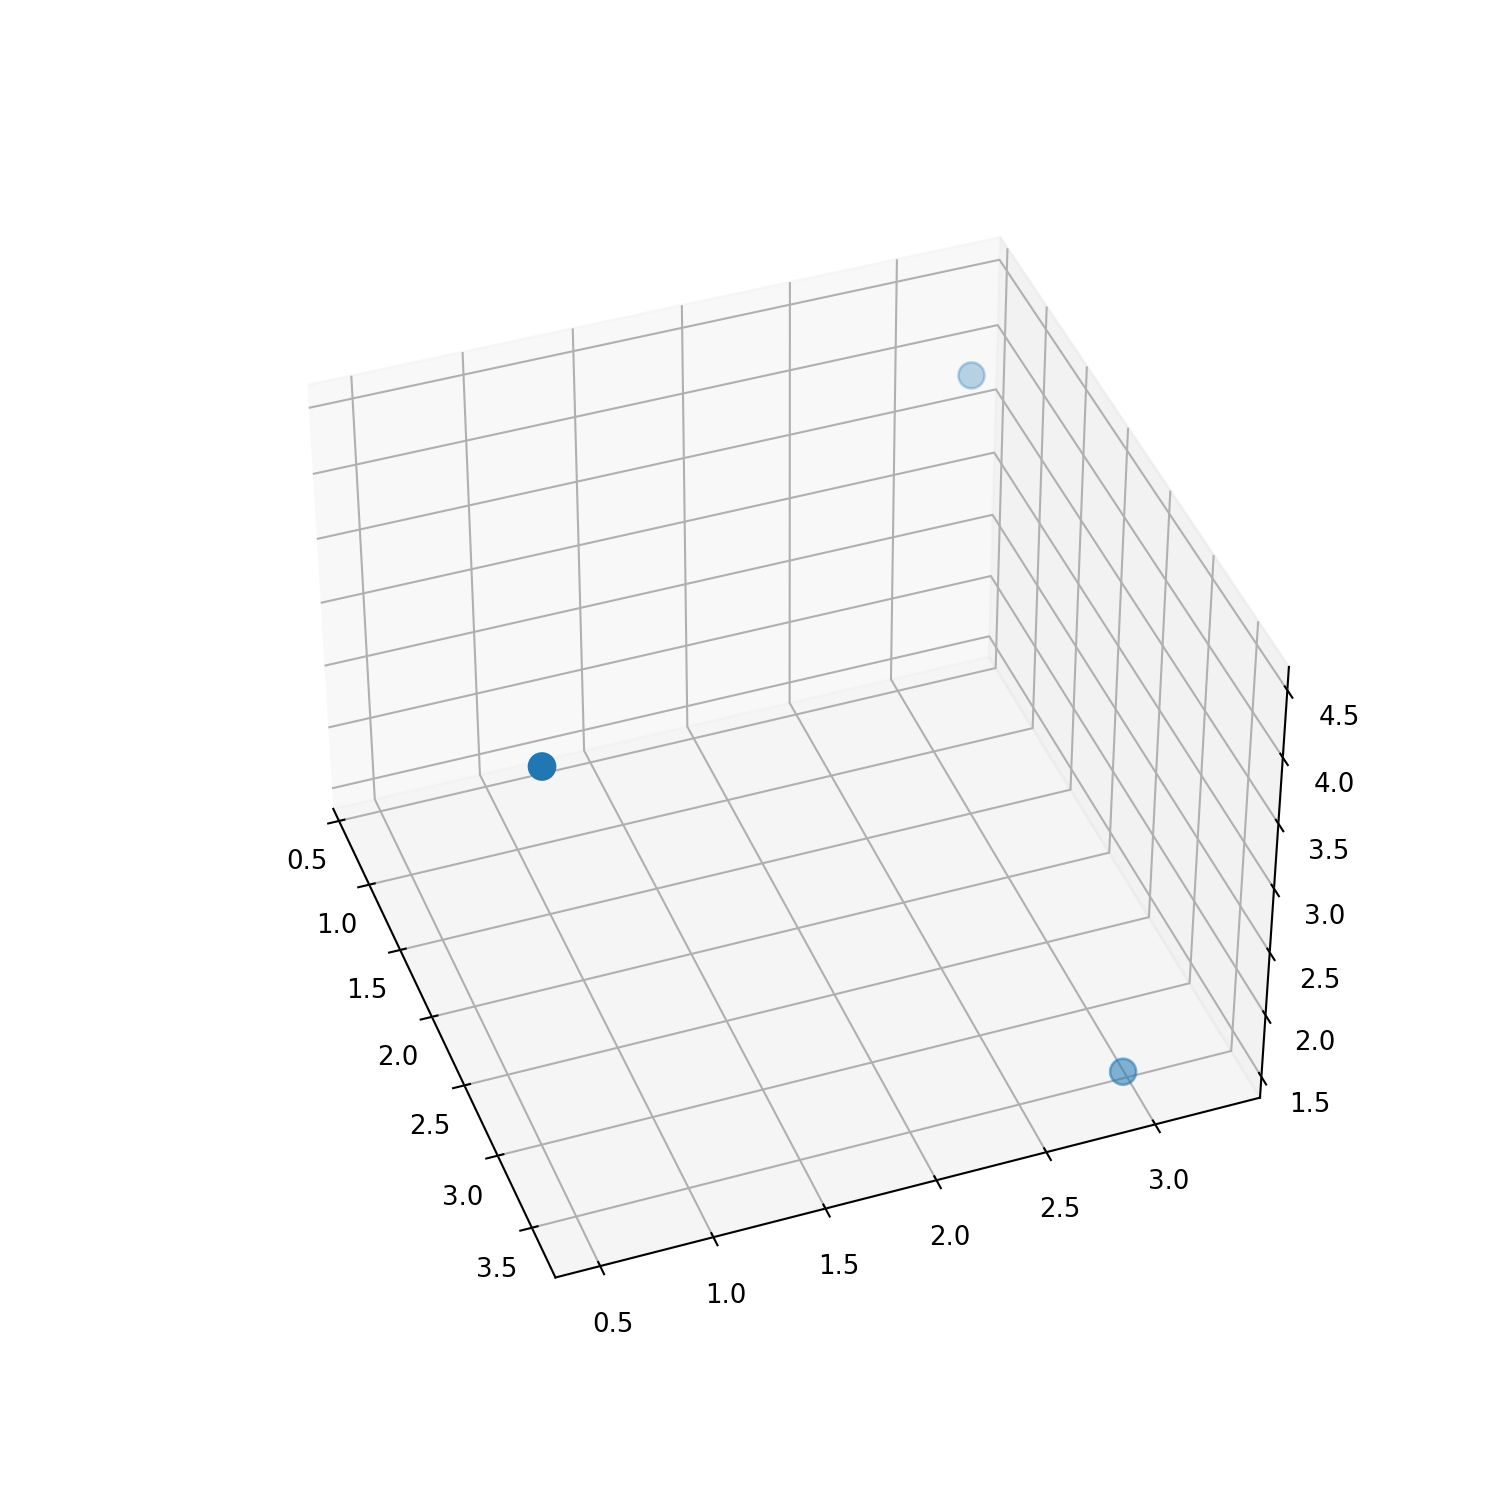

<IPython.core.display.Javascript object>


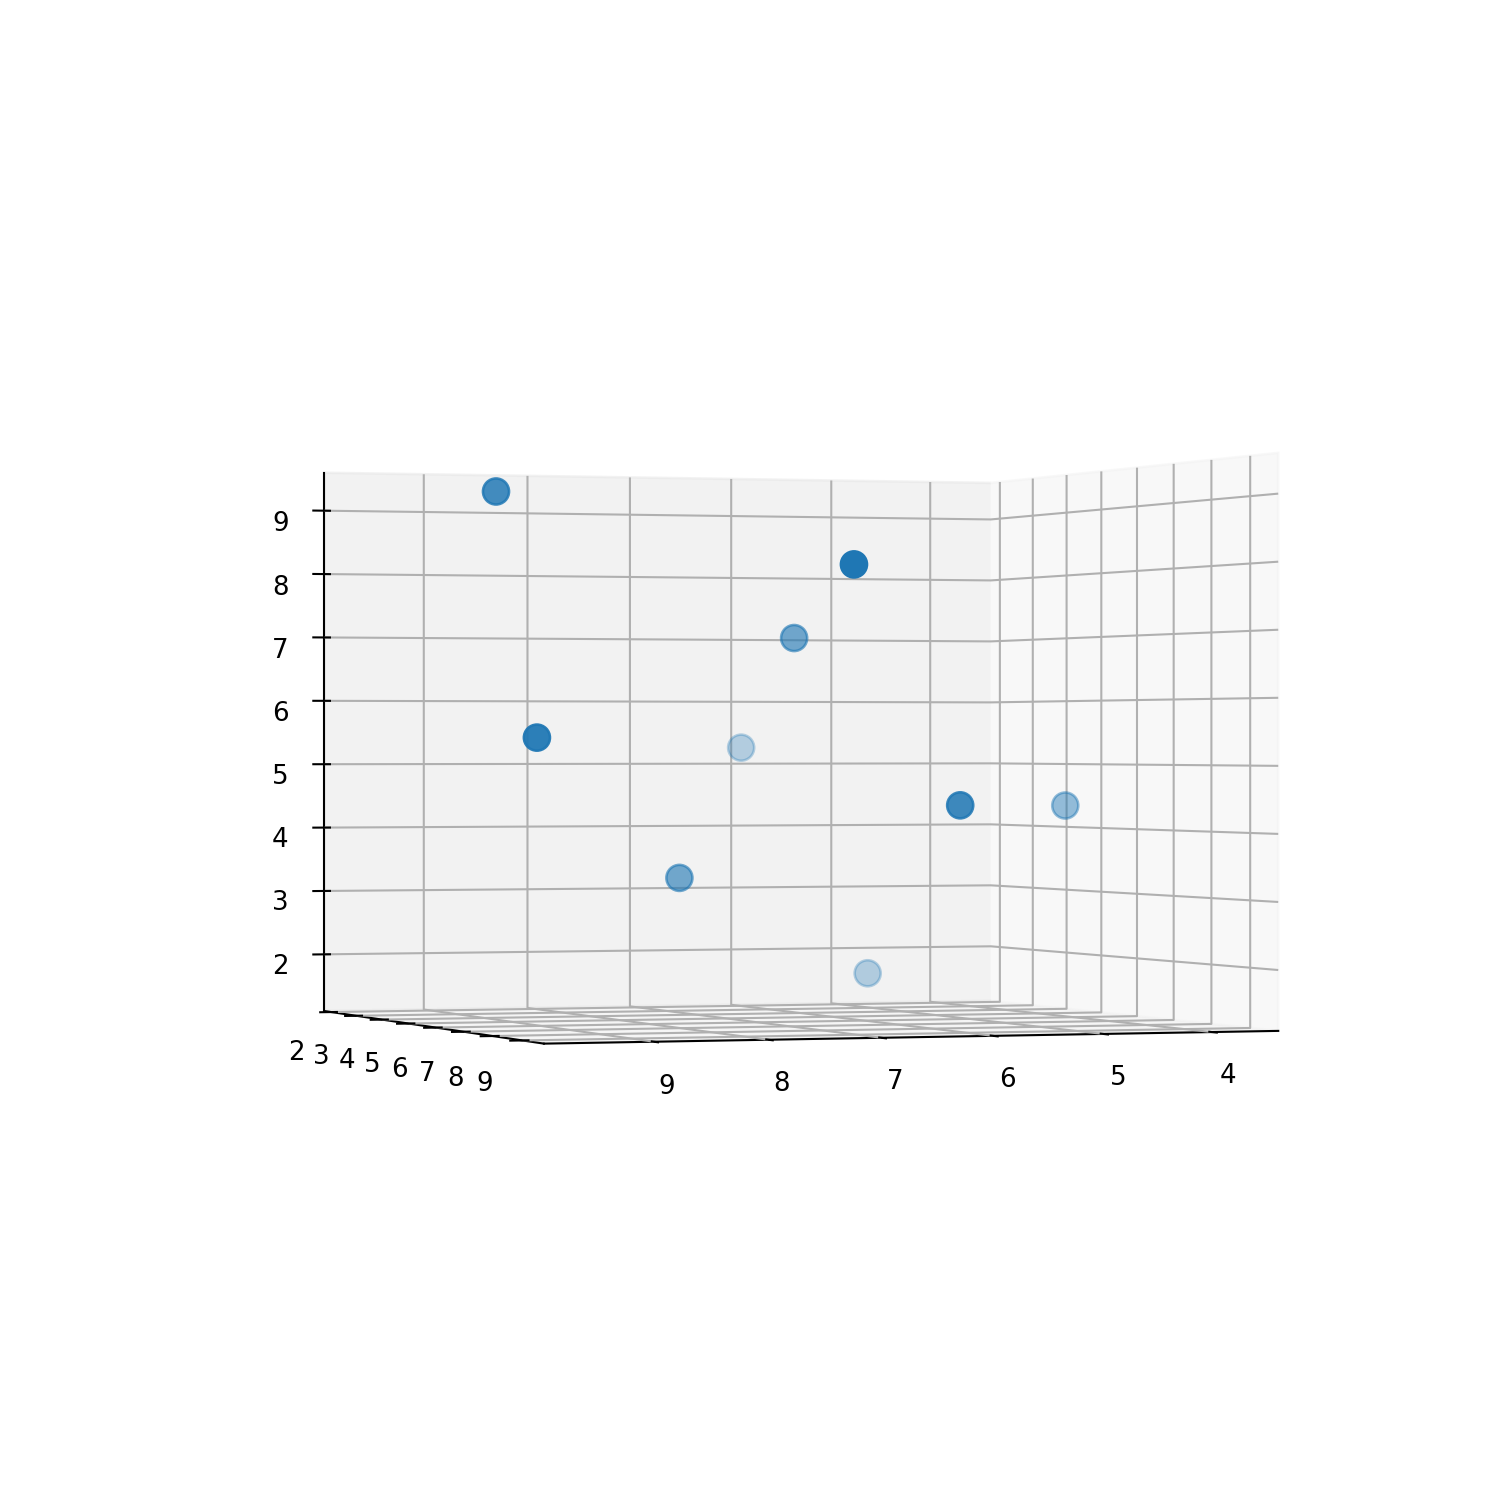

In [627]:
X_min3 = X_min_N[1].reshape(-1,3)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d' )
ax.scatter(X_min3[:,0],X_min3[:,1],X_min3[:,2],marker = 'o', s = 100)
ax.view_init(40, -20)
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
plt.show()
X_min9 = X_min_N[-1].reshape(-1,3)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d' )
ax.scatter(X_min9[:,0],X_min9[:,1],X_min9[:,2],marker = 'o', s = 100)
ax.view_init(0, 70)
plt.show()

In [569]:
def linesearch2(F, X0, d, alpha_max, tol, max_iter):
    """Returns: X = X0+alpha*d such that d@F(X)=0 within tolerance tol or X that
    was computed in the last step once max_iter is reached.\n number of
    function calls."""
    gradF_rest = lambda s: d.flatten()@F(X0+s*d)
    alpha, n_calls = bis(gradF_rest, 0, alpha_max, tol, max_iter)
    return X0+alpha*d, n_calls, alpha

In [ ]:
def golden_section_min(f, a, b, tol = 1e-3):
    """For a strictly unimodal function on the interval [a,b], using golden section search
    Returns: \nminimum x_opt\nnumber of function calls .
    """
    n_calls = 0
    c = b - (b-a)/phi
    d = a + (b-a)/phi
    while abs(c-d)>tol:
        n_calls +=2
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b - a) / phi
        d = a + (b - a) / phi
    return (b+a)/2, n_calls 

In [698]:
def BFGS_ls(f, gradf, X, tol = 1e-6, max_iter = 10000):
    X = np.copy(X)
    N_calls, converged = 0, True
    dfX0 = gradf(X)
    B = np.eye(len(X))#*la.norm(dfX0)#/.001
    while(abs(la.norm(dfX0))>tol and N_calls<=max_iter):
        N_calls+=2
        dx = la.solve(B,-dfX0)
        F_red_line = lambda s: f(X+s*dx)
        alpha, add_calls = golden_section_min(F_red_line, -1, 1, tol = 1e-2)
        N_calls += add_calls
        dx = alpha*dx
        X = X + dx
        dfX = gradf(X)
        dy = dfX-dfX0
        dfX0 = dfX
        B += (np.outer(dy,dy)/(dy@dx) - np.outer(B@dx, B@dx)/(dx@(B@dx)))*1e-2
    if N_calls>=max_iter:
        converged = False
    return X, N_calls, converged

In [699]:
X_min_N2, calls_N2, conv_N2, Distance_N2, num_within2 = [],[],[],[],[]
for i in range(len(ArStarts)):
    X_min, calls, conv = BFGS_ls(V_flat, dV_flat, ArStarts[i][1], tol = 1e-10, max_iter = 10000)
    d = distance(X_min.reshape(-1,3))
    X_min_N2.append(X_min), calls_N2.append(calls)
    conv_N2.append(conv), Distance_N2.append(d)
    num_within2.append(np.sum(abs(Distance_N2[i]-r0_BFGS)/r0_BFGS <= 0.01))
num_within2, calls_N2

([2, 6, 12, 18, 24, 30, 36, 38],
 [400, 760, 1900, 4680, 5040, 4120, 8420, 6600])

<IPython.core.display.Javascript object>


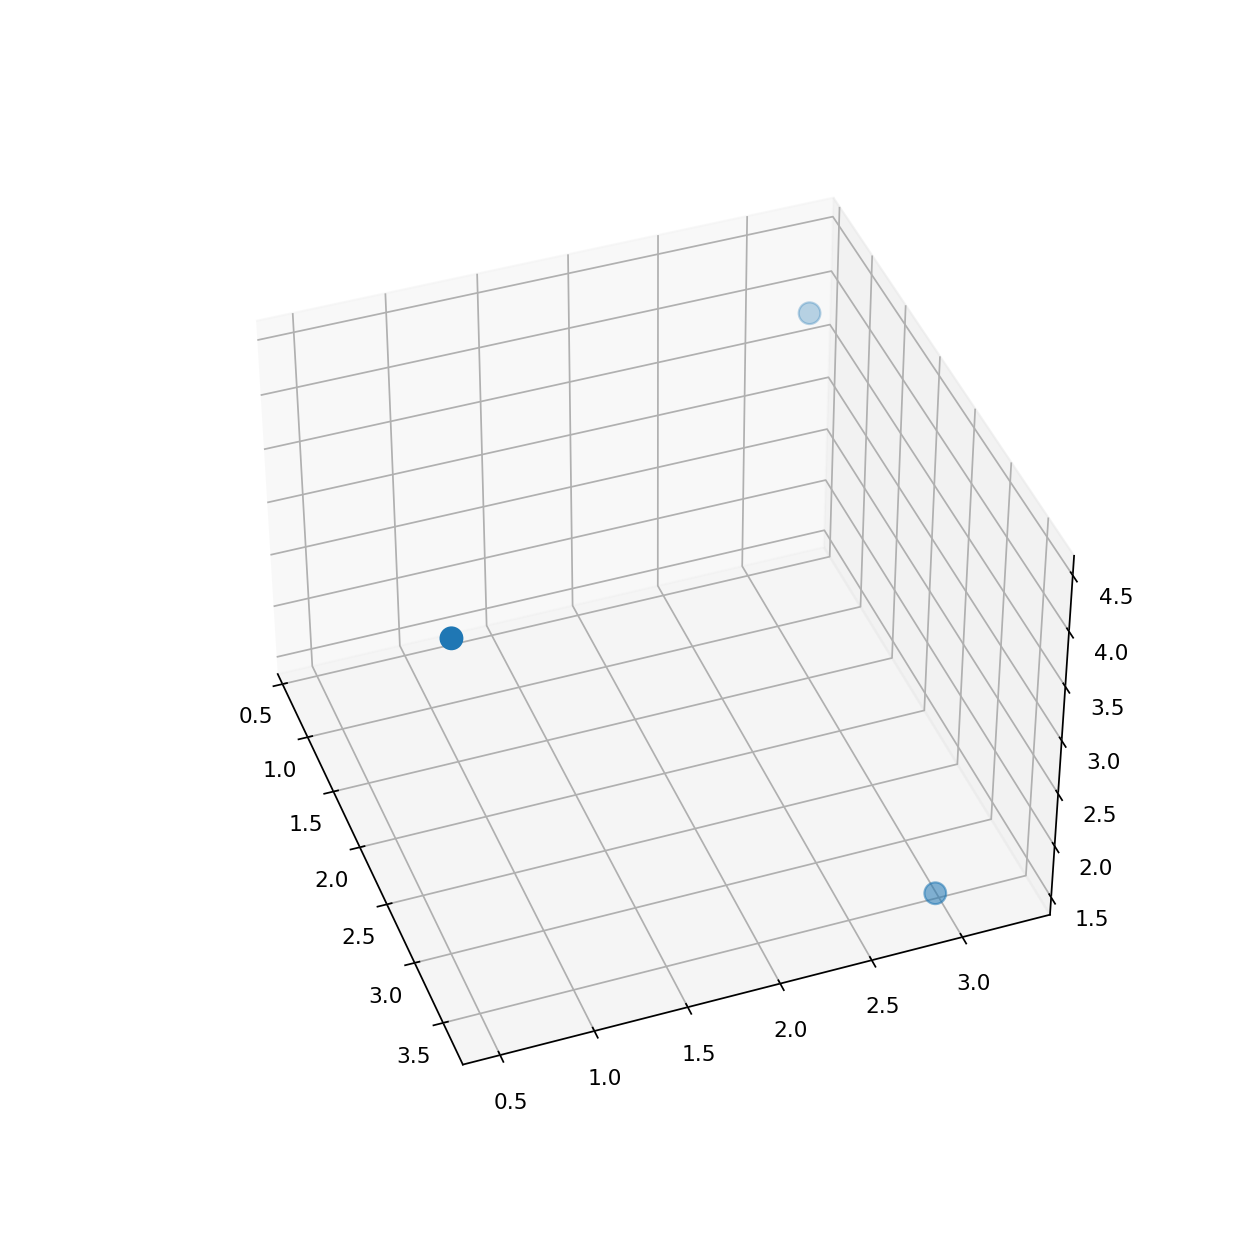

<IPython.core.display.Javascript object>


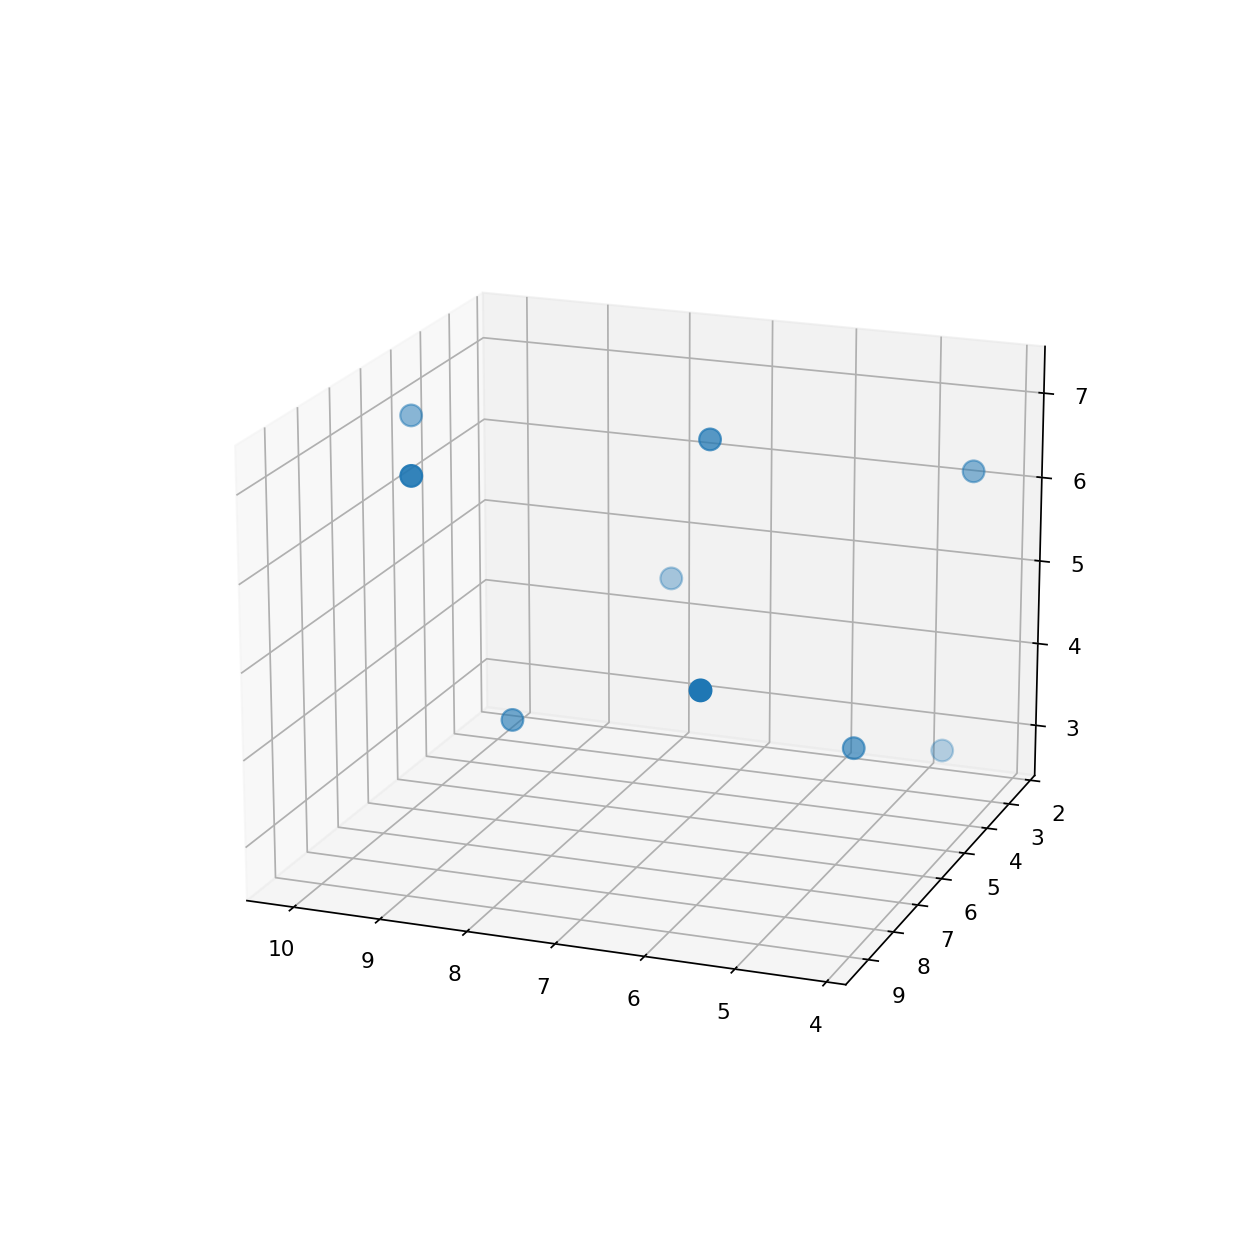

In [700]:
X_min3 = X_min_N2[1].reshape(-1,3)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d' )
ax.scatter(X_min3[:,0],X_min3[:,1],X_min3[:,2],marker = 'o', s = 100)
ax.view_init(40, -20)
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
plt.show()
X_min9 = X_min_N2[-1].reshape(-1,3)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d' )
ax.scatter(X_min9[:,0],X_min9[:,1],X_min9[:,2],marker = 'o', s = 100)
ax.view_init(0, 70)
#plt.show()